## Setup & Libraries

In [1]:
from torchtext import data, datasets
import torch
import spacy
import random
import numpy as np

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
from itertools import product
import pandas as pd

In [2]:
# Load SpaCy
nlp = spacy.load("en_core_web_sm")

 # For tokenization
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm',include_lengths = True, pad_token='<pad>')
# For multi - class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data , test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained = False)
# Split train into train/valid (80/20)
train_data, valid_data = train_data.split(
    split_ratio=0.8,
    random_state=random.seed(42)  # <-- use random.seed here
)

print(f"Train examples: {len(train_data)}")
print(f"Validation examples: {len(valid_data)}")

Train examples: 4362
Validation examples: 1090


In [3]:
print(vars(train_data.examples[0]))

{'text': ['What', 'is', 'the', 'most', 'famous', 'German', 'word', 'in', 'the', 'English', 'language', '?'], 'label': 'ENTY'}


In [4]:
from torchtext.vocab import GloVe, Vectors

# Option 1: Use built-in GloVe (torchtext will download automatically)
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=100))

In [5]:
LABEL.build_vocab(train_data)

## Codes Required from Q1

Vocabulary size: 8093 \
Number of Labels:  6

In [6]:
import torchtext
from collections import defaultdict, Counter
# Get only the GloVe vocab (words with pretrained vectors)
glove_vocab = set(torchtext.vocab.GloVe(name='6B', dim=100).stoi.keys())

oov_words_by_topic = defaultdict(Counter)

for example in train_data.examples:
    label = example.label
    tokens = example.text  # Already tokenized as list of tokens by spacy
    for token in tokens:
        # Lowercase token to match GloVe casing
        token_lower = token.lower()
        if token_lower not in glove_vocab:
            oov_words_by_topic[label][token_lower] += 1

total_oov_words = set()
for counter in oov_words_by_topic.values():
    total_oov_words.update(counter.keys())

total_count = sum(
    count
    for counter in oov_words_by_topic.values()
    for count in counter.values()
)
print(f"Total count of all OOV word occurrences: {total_count}")
print(f"Total number of OOV words in training data: {len(total_oov_words)}")
print("Number of OOV words per topic category:")

for topic, counter in oov_words_by_topic.items():
    print(f"Topic {topic}: {len(counter)} unique OOV words")
    print("Total occurrence of OOV words: ", sum(counter.values()))
    print("-"*50)

Total count of all OOV word occurrences: 202
Total number of OOV words in training data: 190
Number of OOV words per topic category:
Topic DESC: 68 unique OOV words
Total occurrence of OOV words:  69
--------------------------------------------------
Topic ENTY: 47 unique OOV words
Total occurrence of OOV words:  52
--------------------------------------------------
Topic HUM: 39 unique OOV words
Total occurrence of OOV words:  40
--------------------------------------------------
Topic ABBR: 4 unique OOV words
Total occurrence of OOV words:  4
--------------------------------------------------
Topic NUM: 21 unique OOV words
Total occurrence of OOV words:  21
--------------------------------------------------
Topic LOC: 15 unique OOV words
Total occurrence of OOV words:  16
--------------------------------------------------


In [7]:
def replace_oov_with_unk(tokens, glove_vocab):
    return [token if token.lower() in glove_vocab else '<unk>' for token in tokens]

for example in train_data.examples:
    tokens = example.text
    example.text = replace_oov_with_unk(tokens, glove_vocab)

In [8]:
unk_count = 0
for example in train_data.examples:
    label = example.label
    tokens = example.text
    for token in tokens:
        # Lowercase token to match GloVe casing
        token_lower = token.lower()
        if token_lower == "<unk>":
            unk_count += 1
unk_count

202

## Codes Required from Q2

In [9]:
# Define Dataset Class for Qn 2 - Make them learnable parameters
class SentenceDataset(Dataset):
    def __init__(self, text, label, vocab):
        self.text = text
        self.label = label
        self.vocab = vocab

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        tokens = self.text[idx].split()
        label = self.label[idx]
        indices = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]

        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=TEXT.vocab.stoi['<pad>'])
    labels = torch.stack(labels)
    return texts_padded, labels

In [10]:
# Create train, valid, test texts and labels 
train_texts = [" ".join(example.text) for example in train_data.examples]
train_labels = [LABEL.vocab.stoi[example.label] for example in train_data.examples]

valid_texts = [" ".join(example.text) for example in valid_data.examples]
valid_labels = [LABEL.vocab.stoi[example.label] for example in valid_data.examples]

test_texts = [" ".join(example.text) for example in test_data.examples]
test_labels = [LABEL.vocab.stoi[example.label] for example in test_data.examples]

# Create Dataset instances
train_dataset = SentenceDataset(train_texts, train_labels, TEXT.vocab.stoi)
valid_dataset = SentenceDataset(valid_texts, valid_labels, TEXT.vocab.stoi)
test_dataset = SentenceDataset(test_texts, test_labels, TEXT.vocab.stoi)

# Check length of train dataset and train data
print(len(train_dataset))
print(len(train_data))

4362
4362


In [12]:
# Define the RNN Classifier, here we do only a single hidden layer to keep it small and simple
# We take input word embeddings, pass through RNN, apply dropout, and then a fully connected layer to get logits for 6 classes (as per qn requirement)
class ClassifierRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, dropout=0.0):
        super(ClassifierRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 6) # since 6 possible labels

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1]) # Default is to take last layer's hidden state
        out = self.fc(hidden)
        return out

In [13]:
# Define training, evaluation, and testing loops
def train_loop(model, loader, optimizer, criterion, grad_clip=False, max_norm=1.0):
    model.train()
    total_loss, total_correct = 0, 0
    for texts, labels in loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        if grad_clip:
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct

def eval_loop(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct
    
def test_loop(model, loader):
    model.eval()
    total_correct = 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            total_correct += (outputs.argmax(1) == labels).sum().item()
    
    acc = total_correct / len(loader.dataset)
    return acc

# Early stopper to prevent overfitting as default to determine a suitable num_epochs, 
# here we use val_acc as the metrics as recommended metrics for training (as per qn requirements)
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = float('-inf')

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc + self.min_delta:
            self.max_validation_acc = validation_acc
            self.counter = 0
        else:
            self.counter += 1
            return self.counter >= self.patience

In [14]:
# Function to capture metrics and print training results per epoch
def training_step(model, train_loader, valid_loader, optimizer, criterion, num_epochs, grad_clip=False, max_norm=1.0):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    early_stopper = EarlyStopper(patience=5, min_delta=0)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_loop(model, train_loader, optimizer, criterion, grad_clip=grad_clip, max_norm=max_norm)
        valid_loss, valid_acc = eval_loop(model, valid_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}:")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
        print(f"Valid loss: {valid_loss:.4f}, Valid acc: {valid_acc:.4f}")

        if early_stopper.early_stop(valid_acc):
            print("Early Stopping Triggered! No Improvements to Validation Accuracy within Patience.")
            no_epochs = epoch+1
            break

        no_epochs = epoch+1

    return train_losses, train_accuracies, valid_losses, valid_accuracies, no_epochs

### Answer (a):
Final Configuration of Best Model:
Number of training epochs = 42 \
Learning rate = 0.0001 \
Optimizer = Adam \
Batch Size = 32 \
Hidden dimension = 256\
Best validation accuracy based on optimal parameters: 0.7936

## Q3. Enhancement 

This section implements a CNN to produce sentence representations and perform topic classification. 

In [25]:
# Define the CNN Classifier for sentence representation and topic classification
# We use multiple filter sizes to capture different n-gram patterns, then apply max pooling and dropout
class ClassifierCNN(nn.Module):
    def __init__(self, embedding_matrix, num_filters=100, filter_sizes=[3, 4, 5], dropout=0.0):
        super(ClassifierCNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        
        # Multiple convolutional layers with different filter sizes to capture n-grams
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.dropout = nn.Dropout(dropout)
        # Fully connected layer: num_filters * len(filter_sizes) because we concatenate all conv outputs
        self.fc = nn.Linear(num_filters * len(filter_sizes), 6)  # 6 possible labels

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # Conv1d expects input of shape (batch_size, embedding_dim, seq_len)
        embedded = embedded.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)
        
        # Apply convolutions and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = torch.relu(conv(embedded))  # (batch_size, num_filters, conv_seq_len)
            pooled = torch.max_pool1d(conv_out, kernel_size=conv_out.size(2))  # (batch_size, num_filters, 1)
            conv_outputs.append(pooled.squeeze(2))  # (batch_size, num_filters)
        
        # Concatenate all conv outputs
        concatenated = torch.cat(conv_outputs, dim=1)  # (batch_size, num_filters * len(filter_sizes))
        
        # Apply dropout and final classification
        dropped = self.dropout(concatenated)
        out = self.fc(dropped)
        return out



In [27]:
cnn_model = ClassifierCNN(
    embedding_matrix=TEXT.vocab.vectors,
    num_filters=100,
    filter_sizes=[3,4,5],
    dropout=0.5
)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

train_losses, train_accuracies, valid_losses, valid_accuracies, no_epochs = training_step(
    cnn_model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    num_epochs=50
)



/var/folders/bw/_dd4c0bn1ws10nbrwf6ls6hc0000gn/T/ipykernel_4574/43816942.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)


Epoch 1:
Train loss: 1.6399, Train acc: 0.2772
Valid loss: 1.5572, Valid acc: 0.3954
Epoch 2:
Train loss: 1.5169, Train acc: 0.3806
Valid loss: 1.4699, Valid acc: 0.4624
Epoch 3:
Train loss: 1.4156, Train acc: 0.4663
Valid loss: 1.3956, Valid acc: 0.5165
Epoch 4:
Train loss: 1.3190, Train acc: 0.5298
Valid loss: 1.3195, Valid acc: 0.5495
Epoch 5:
Train loss: 1.2300, Train acc: 0.5782
Valid loss: 1.2383, Valid acc: 0.5890
Epoch 6:
Train loss: 1.1495, Train acc: 0.6080
Valid loss: 1.1647, Valid acc: 0.6046
Epoch 7:
Train loss: 1.0709, Train acc: 0.6373
Valid loss: 1.0996, Valid acc: 0.6248
Epoch 8:
Train loss: 0.9899, Train acc: 0.6614
Valid loss: 1.0289, Valid acc: 0.6495
Epoch 9:
Train loss: 0.9189, Train acc: 0.6933
Valid loss: 0.9664, Valid acc: 0.6734
Epoch 10:
Train loss: 0.8457, Train acc: 0.7290
Valid loss: 0.9019, Valid acc: 0.6991
Epoch 11:
Train loss: 0.7774, Train acc: 0.7451
Valid loss: 0.8520, Valid acc: 0.7037
Epoch 12:
Train loss: 0.7202, Train acc: 0.7669
Valid loss: 0.7

In [28]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_acc = test_loop(cnn_model, test_loader)
print(f"Final Test Accuracy (CNN): {test_acc:.4f}")

Final Test Accuracy (CNN): 0.9080


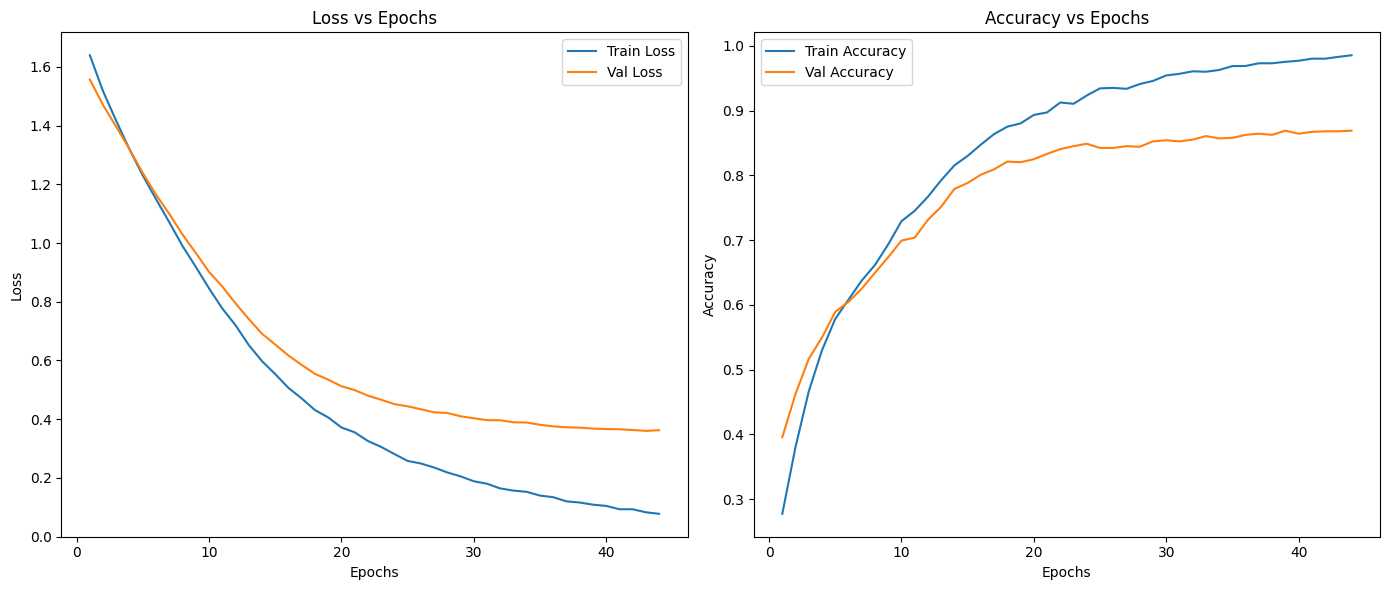

In [30]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# ---- Left: Loss vs Epochs ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# ---- Right: Accuracy vs Epochs ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Hyperparameters of CNN: 
1. Learning Rate
2. Optimisers
3. Batch Size
4. Number of Filters
